In [1]:
from MutantTool import Placeholder, QCSetUp
from MTMutationTool import mutation_MT
from basicFunctions import xor

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Instruction 
from qiskit.circuit.gate import Gate
from qiskit_textbook.tools import simon_oracle

In [16]:
def Simon_Alg_MT(n:int):
    
    qs=QuantumRegister(n, 's')
    anc=QuantumRegister(n, 'anc')
    qc = QuantumCircuit(qs, anc)

    for i in range(n): qc.h(i)

    qc.barrier()
    qc.append(Placeholder(qc.num_qubits, qc.qubits))
    qc.barrier()
    
    for i in range(n): qc.h(i) 
    
    return qc

def sumgate(n: int) -> QuantumCircuit:
    qubits=4*n
    qc = QuantumCircuit(qubits)
    for i in range(n):
        qc.cx(i,2*n+i)
    return qc

def Simon_TestMT1_Output(qc: QuantumCircuit, n: int):
    suma = sumgate(n)
    sgate = suma.to_instruction(label='  Metamorphic \n\n Relation \n\n Outputs')
    qc.append(sgate, range(4*n))
    for i in range(n):
        qc.measure(2*n+i, i)

def Simon_MT1(mutant:QuantumCircuit, inputs: list[str]) -> QuantumCircuit:

    assert len(inputs) == 2
    assert mutant.num_qubits % 2 == 0
    
    n = mutant.num_qubits//2
           
    qs=QuantumRegister(n, 's')
    anc=QuantumRegister(n, 'anc1')
    qs1=QuantumRegister(n, 's1')
    anc1=QuantumRegister(n, 'anc2')
    c_test=ClassicalRegister(n, 'c_test')
    qc = QuantumCircuit(qs, anc, qs1, anc1, c_test)
    
    f_s=simon_oracle(inputs[0])
    gate_s = QCSetUp(mutant,f_s)
    gate_s.name='  Simon_oracle  \n \ns='+ inputs[0]
    qc.append(gate_s, range(2*n))
    qc.append(gate_s, range(2*n,4*n))
    
    qc.barrier()
    
    Simon_TestMT1_Output(qc,n)
    
    qc.draw(output='mpl')
    
    return qc

def Simon_TestMT2_Output(qc: QuantumCircuit, n: int):
    for i in range(n):
        qc.measure(i, i)
        qc.measure(2*n+i, n+i)

def Simon_MT2(mutant:QuantumCircuit, inputs: list[str]) -> QuantumCircuit:

    assert len(inputs) == 2
    assert mutant.num_qubits % 2 == 0
    
    n = mutant.num_qubits//2
           
    qs=QuantumRegister(n, 's')
    anc=QuantumRegister(n, 'anc1')
    qs1=QuantumRegister(n, 's1')
    anc1=QuantumRegister(n, 'anc2')
    c_test=ClassicalRegister(2*n, 'c_test')
    qc = QuantumCircuit(qs, anc, qs1, anc1, c_test)
    
    f_s=simon_oracle(inputs[0])
    gate_s = QCSetUp(mutant,f_s)
    gate_s.name='  Simon_oracle  \n \ns='+ inputs[0]
    qc.append(gate_s, range(2*n))
    
    f_s1=simon_oracle(inputs[0][::-1])
    gate_s1 = QCSetUp(mutant,f_s)
    gate_s1.name='  Simon_oracle  \n \ns='+ inputs[0]
    qc.append(gate_s, range(2*n,4*n))
    
    qc.barrier()
    
    Simon_TestMT2_Output(qc,n)
    
    qc.draw(output='mpl')
    
    return qc



In [3]:
from MutantTool import mutant_generator
from basicFunctions import xor, input_generator
import random
from qiskit import QuantumCircuit, transpile, Aer
from qiskit.providers.aer import QasmSimulator

svsim = Aer.get_backend('aer_simulator')
simulator = QasmSimulator()

In [4]:
original_algorithm = Simon_Alg_MT
num_qubits = 3
num_mutants = 10
num_inputs = 10

originalQC = original_algorithm(num_qubits)
mutants = mutant_generator(originalQC, num_mutants)
input_list = input_generator(num_qubits,num_inputs)
input_pairs = [[input_list[i],input_list[random.randint(0,len(input_list)-1)]]for i in range(len(input_list))]

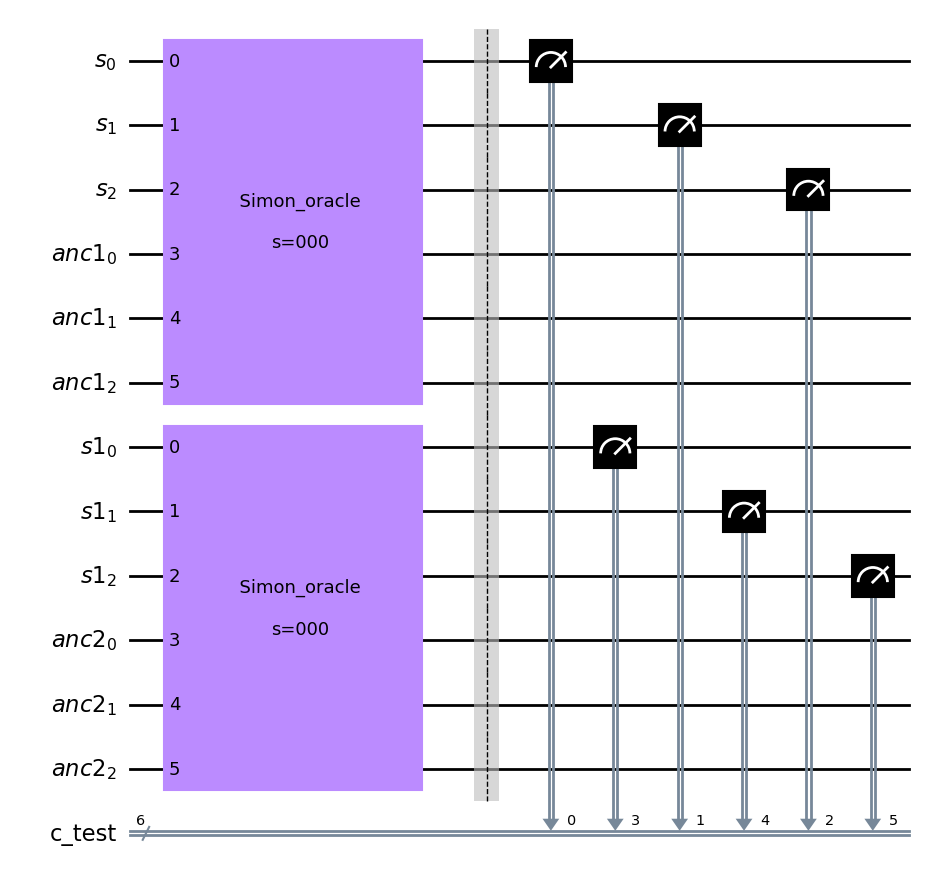

In [17]:
b=Simon_MT2(mutants[0],input_pairs[0])
b.draw(output='mpl')

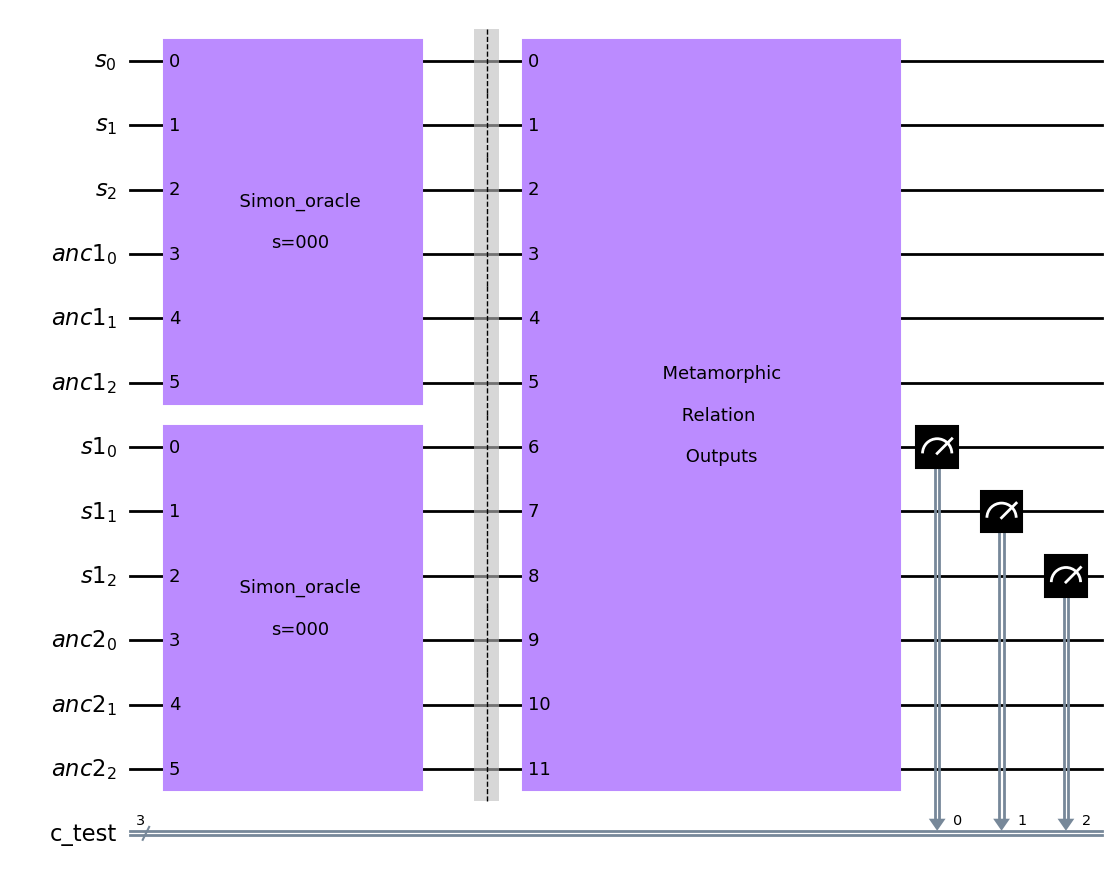

In [5]:
a=Simon_MT1(mutants[0],input_pairs[0])
a.draw(output='mpl')

In [6]:
result_x_i=svsim.run(transpile(a,svsim),shots=1024).result().get_counts()
print(result_x_i)

{'010': 119, '000': 137, '110': 133, '001': 144, '100': 128, '101': 113, '111': 129, '011': 121}


000 3


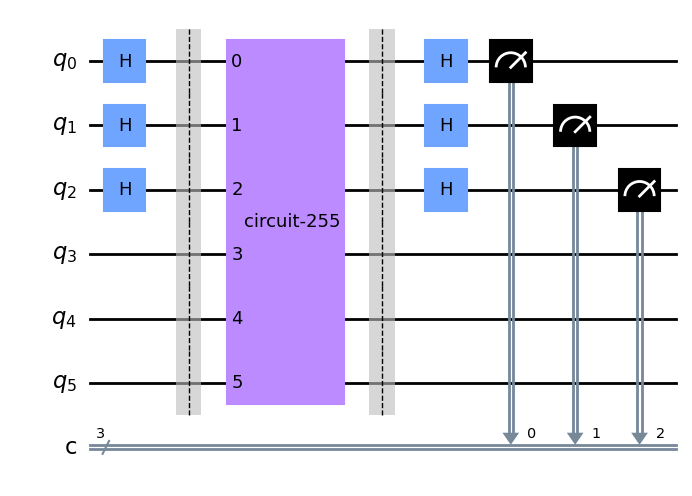

In [7]:
b=input_pairs[0][0]
n=len(b)
print(b,n)

Orig =QuantumCircuit(n*2, n)

Orig.h(range(n))    
    
Orig.barrier()

Orig.append(simon_oracle(b),range(2*n))

Orig.barrier()

Orig.h(range(n))

Orig.measure(range(n), range(n))

Orig.draw(output='mpl')

In [8]:
result_main=svsim.run(transpile(Orig,svsim),shots=1024).result().get_counts()
print(result_main)

{'001': 149, '110': 117, '100': 126, '011': 106, '111': 141, '101': 129, '000': 141, '010': 115}


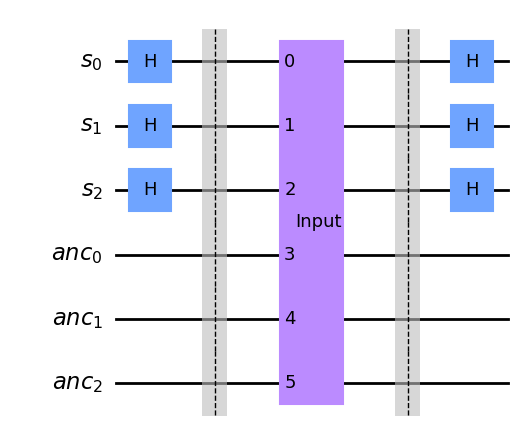

In [9]:
originalQC.draw(output='mpl')

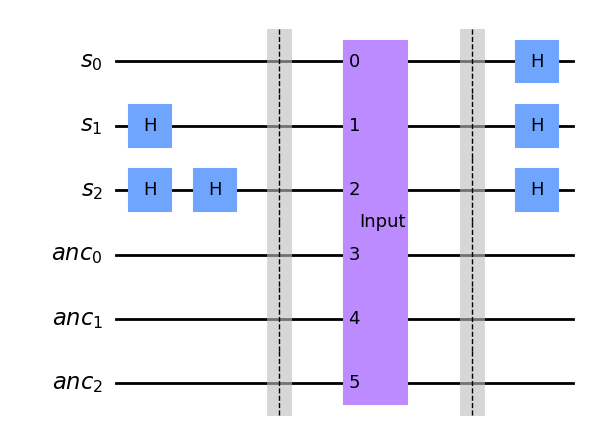

In [10]:
mutants[0].draw(output='mpl')

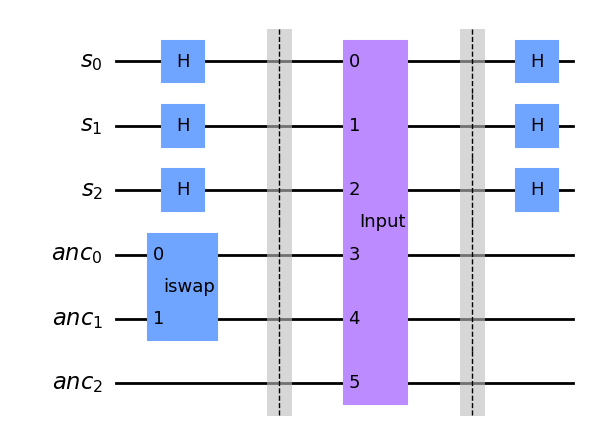

In [11]:
mutants[1].draw(output='mpl')

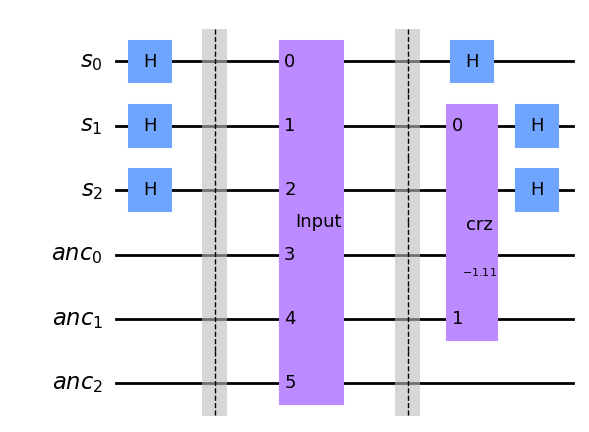

In [12]:
mutants[2].draw(output='mpl')

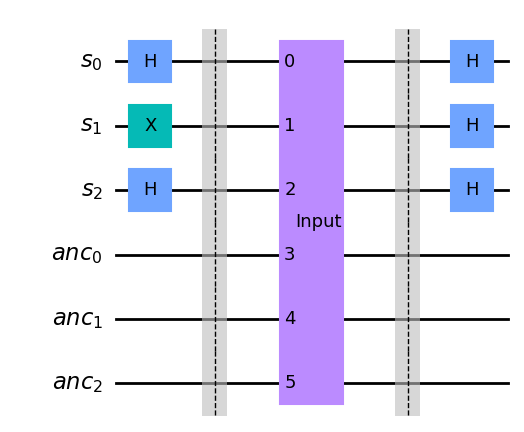

In [13]:
mutants[3].draw(output='mpl')

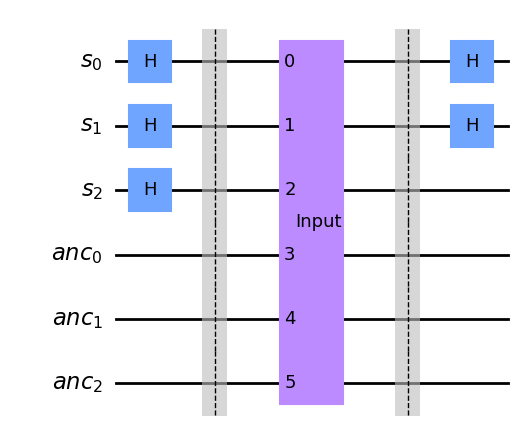

In [14]:
mutants[4].draw(output='mpl')

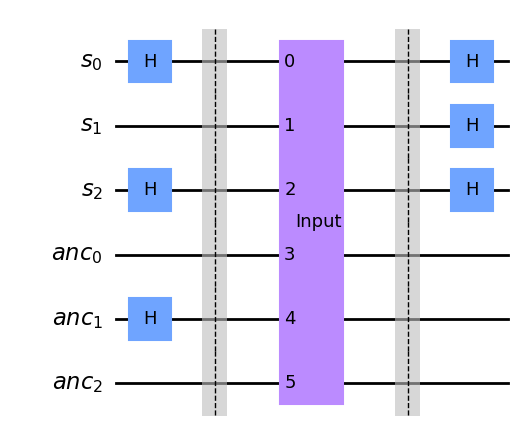

In [15]:
mutants[5].draw(output='mpl')